In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [9]:
disease_type = ['Healthy','Mosaic']
data_path = 'E:/Crop_disease/dataset/datasets/Field/Cluster_bean/'
train_dir = os.path.join(data_path)

In [10]:
os.listdir(train_dir)

['Healthy', 'Mosaic']

In [11]:
train_data = []
for id, sp in enumerate(disease_type):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [12]:
train.head(500)

,File,DiseaseID,Disease Type
0,Healthy/.trashed-1668312159-IMG20221013165532.jpg,0,Healthy
1,Healthy/IMG20221013164438.jpg,0,Healthy
2,Healthy/IMG20221013164445.jpg,0,Healthy
3,Healthy/IMG20221013164450.jpg,0,Healthy
4,Healthy/IMG20221013164454.jpg,0,Healthy
...,...,...,...
495,Mosaic/IMG_20221013_165412.jpg,1,Mosaic
496,Mosaic/IMG_20221013_165420.jpg,1,Mosaic
497,Mosaic/IMG_20221013_165431.jpg,1,Mosaic
498,Mosaic/IMG_20221013_165434.jpg,1,Mosaic


In [13]:
len(train)

695

In [14]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Healthy/IMG20221015075636.jpg,0,Healthy
1,Mosaic/IMG_20221013_172013.jpg,1,Mosaic
2,Healthy/IMG20221013171258.jpg,0,Healthy
3,Healthy/IMG20221015074756.jpg,0,Healthy
4,Healthy/IMG20221015074152.jpg,0,Healthy


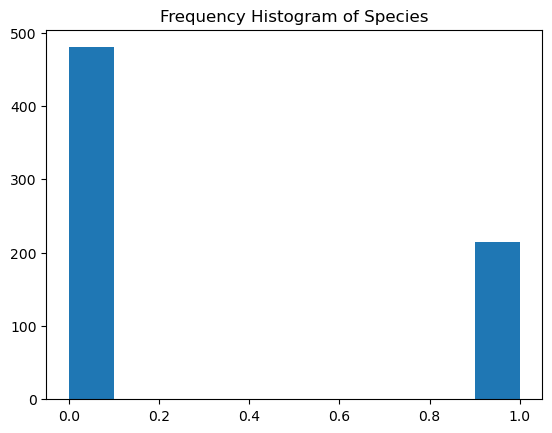

<Figure size 1200x1200 with 0 Axes>

In [15]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

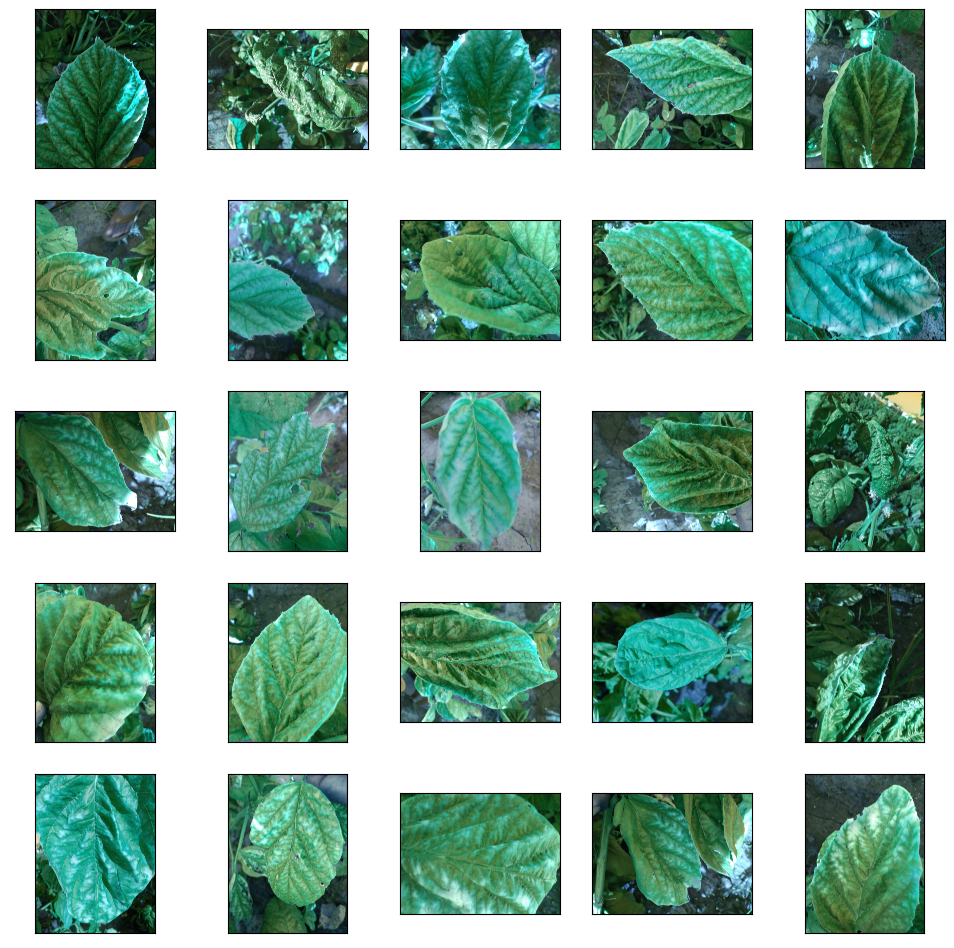

In [16]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_path, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Mosaic', 5, 5)

In [17]:
IMAGE_SIZE = 64

def read_image(filepath):
    return cv2.imread(os.path.join(data_path, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [18]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

695it [02:50,  4.07it/s]

Train Shape: (695, 64, 64, 3)


In [19]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [20]:
BATCH_SIZE = 64

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

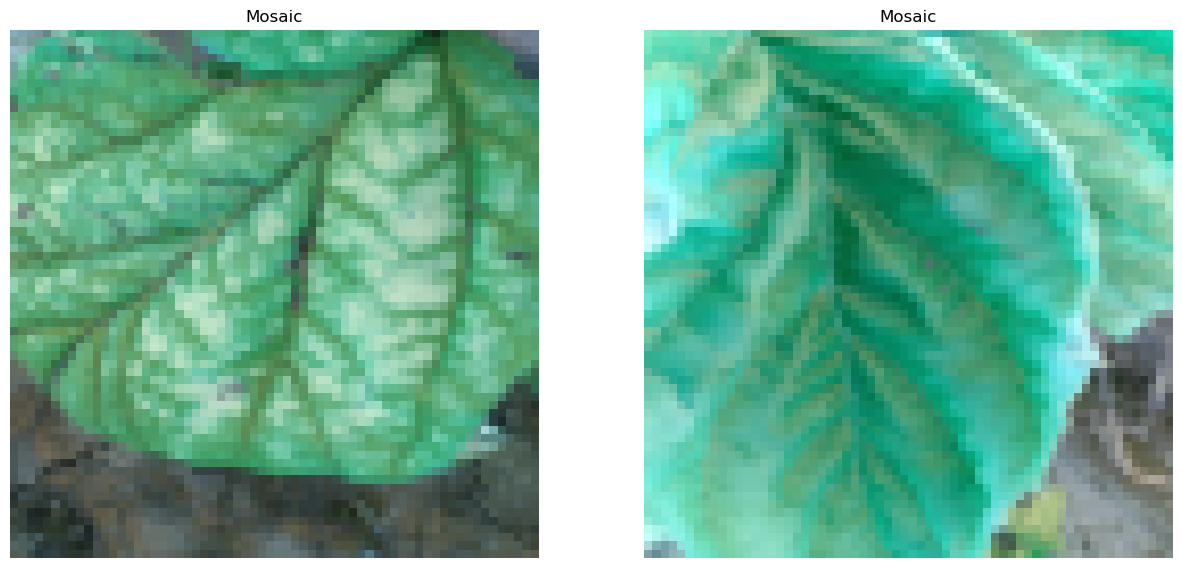

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
for i in range(2):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_type[np.argmax(Y_train[i])])

In [22]:
EPOCHS = 100
SIZE=64
N_ch=3

In [23]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [24]:
from collections import Counter
print(Counter(train['Disease Type']))

Counter({'Healthy': 480, 'Mosaic': 215})


In [25]:
class_weights = {0:480/588, 1:215/588}

In [26]:
class_weights

{0: 0.8163265306122449, 1: 0.3656462585034014}

In [27]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=16),
               steps_per_epoch=X_train.shape[0] // 16,
               epochs=100,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val),
               class_weight = class_weights)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024)  7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

C:\Users\User1\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\User1\AppData\Local\Temp\26\ipykernel_26468\772981173.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=16),


Epoch 1/100

Epoch 1: val_loss improved from inf to 0.72884, saving model to model.h5
34/34 - 34s - loss: 0.8006 - accuracy: 0.5593 - val_loss: 0.7288 - val_accuracy: 0.4317 - lr: 0.0020 - 34s/epoch - 1s/step
Epoch 2/100

Epoch 2: val_loss improved from 0.72884 to 0.52056, saving model to model.h5
34/34 - 7s - loss: 0.6797 - accuracy: 0.6130 - val_loss: 0.5206 - val_accuracy: 0.7266 - lr: 0.0020 - 7s/epoch - 197ms/step
Epoch 3/100

Epoch 3: val_loss did not improve from 0.52056
34/34 - 5s - loss: 0.5773 - accuracy: 0.7111 - val_loss: 0.5513 - val_accuracy: 0.7554 - lr: 0.0020 - 5s/epoch - 155ms/step
Epoch 4/100

Epoch 4: val_loss did not improve from 0.52056
34/34 - 5s - loss: 0.4408 - accuracy: 0.7481 - val_loss: 0.7147 - val_accuracy: 0.6906 - lr: 0.0020 - 5s/epoch - 152ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.52056
34/34 - 5s - loss: 0.3561 - accuracy: 0.7944 - val_loss: 0.7661 - val_accuracy: 0.6978 - lr: 0.0020 - 5s/epoch - 154ms/step
Epoch 6/100

Epoch 6: val

34/34 - 5s - loss: 0.0547 - accuracy: 0.9648 - val_loss: 0.0572 - val_accuracy: 0.9856 - lr: 0.0010 - 5s/epoch - 156ms/step
Epoch 43/100

Epoch 43: val_loss did not improve from 0.04028
34/34 - 5s - loss: 0.0418 - accuracy: 0.9778 - val_loss: 0.0533 - val_accuracy: 0.9856 - lr: 0.0010 - 5s/epoch - 156ms/step
Epoch 44/100

Epoch 44: val_loss did not improve from 0.04028
34/34 - 5s - loss: 0.0771 - accuracy: 0.9500 - val_loss: 0.0590 - val_accuracy: 0.9712 - lr: 0.0010 - 5s/epoch - 155ms/step
Epoch 45/100

Epoch 45: val_loss did not improve from 0.04028
34/34 - 5s - loss: 0.0608 - accuracy: 0.9574 - val_loss: 0.0626 - val_accuracy: 0.9784 - lr: 0.0010 - 5s/epoch - 152ms/step
Epoch 46/100

Epoch 46: val_loss did not improve from 0.04028
34/34 - 5s - loss: 0.0571 - accuracy: 0.9611 - val_loss: 0.0509 - val_accuracy: 0.9856 - lr: 0.0010 - 5s/epoch - 154ms/step
Epoch 47/100

Epoch 47: val_loss did not improve from 0.04028
34/34 - 5s - loss: 0.0583 - accuracy: 0.9630 - val_loss: 0.1529 - val_

Epoch 86/100

Epoch 86: val_loss did not improve from 0.02052
34/34 - 5s - loss: 0.0421 - accuracy: 0.9685 - val_loss: 0.0523 - val_accuracy: 0.9712 - lr: 0.0010 - 5s/epoch - 155ms/step
Epoch 87/100

Epoch 87: val_loss did not improve from 0.02052
34/34 - 5s - loss: 0.0311 - accuracy: 0.9759 - val_loss: 0.1235 - val_accuracy: 0.9568 - lr: 0.0010 - 5s/epoch - 151ms/step
Epoch 88/100

Epoch 88: val_loss did not improve from 0.02052
34/34 - 5s - loss: 0.0304 - accuracy: 0.9761 - val_loss: 0.0593 - val_accuracy: 0.9640 - lr: 0.0010 - 5s/epoch - 155ms/step
Epoch 89/100

Epoch 89: val_loss did not improve from 0.02052
34/34 - 5s - loss: 0.0287 - accuracy: 0.9870 - val_loss: 0.0841 - val_accuracy: 0.9640 - lr: 0.0010 - 5s/epoch - 151ms/step
Epoch 90/100

Epoch 90: val_loss did not improve from 0.02052
34/34 - 5s - loss: 0.0469 - accuracy: 0.9741 - val_loss: 0.0509 - val_accuracy: 0.9856 - lr: 0.0010 - 5s/epoch - 155ms/step
Epoch 91/100

Epoch 91: val_loss did not improve from 0.02052
34/34 - 

In [28]:
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

5/5 [==============================] - 0s 58ms/step - loss: 0.0456 - accuracy: 0.9784
Final Loss: 0.04562333971261978, Final Accuracy: 0.9784172773361206


5/5 [==============================] - 2s 56ms/step


Text(0.5, 192.72222222222217, 'Predicted')

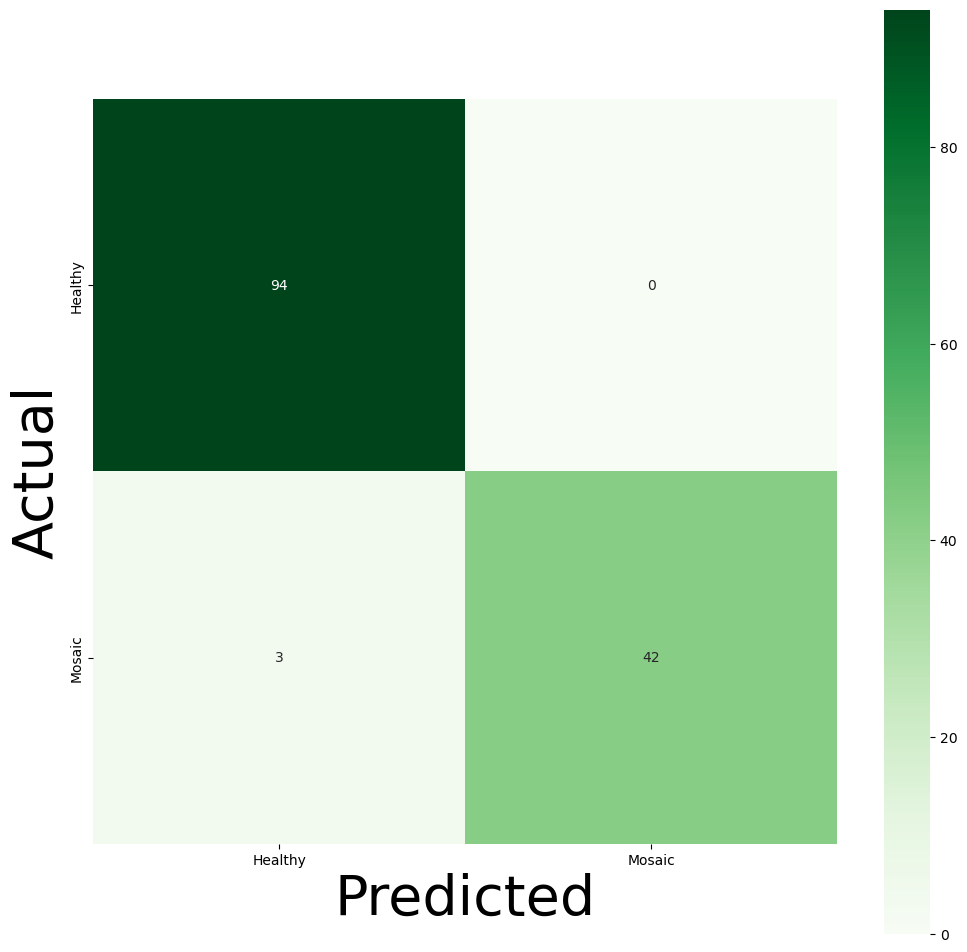

In [29]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_type, yticklabels=disease_type)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

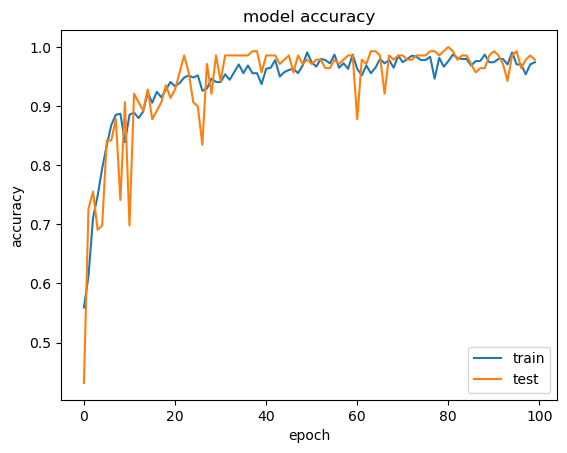

In [30]:
# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

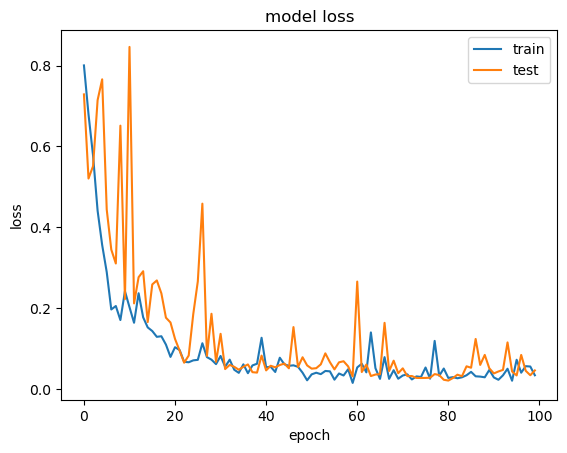

In [31]:
# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()